In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from PIL import Image
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2024-02-07 09:39:46.182342: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-07 09:39:46.184063: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-07 09:39:46.206598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 09:39:46.206630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 09:39:46.207328: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# load data using tf.keras.utils.image_dataset_from_directory

In [2]:
data_dir = '/home/meriem-mk/Downloads/food101/food-101/food-101/images'
data_dir = pathlib.Path(data_dir).with_suffix('')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4000


In [4]:
batch_size = 34
img_height = 512
img_width = 512

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 4 classes.
Using 3200 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 4 classes.
Using 800 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['french_fries', 'pizza', 'spaghetti_carbonara', 'waffles']


<h5>  Here I deleted the majority of subdirectories and only kept 4 subdirectories from the entire food101 dataset(4 classes) </h5>

# visualize random images from the dataset

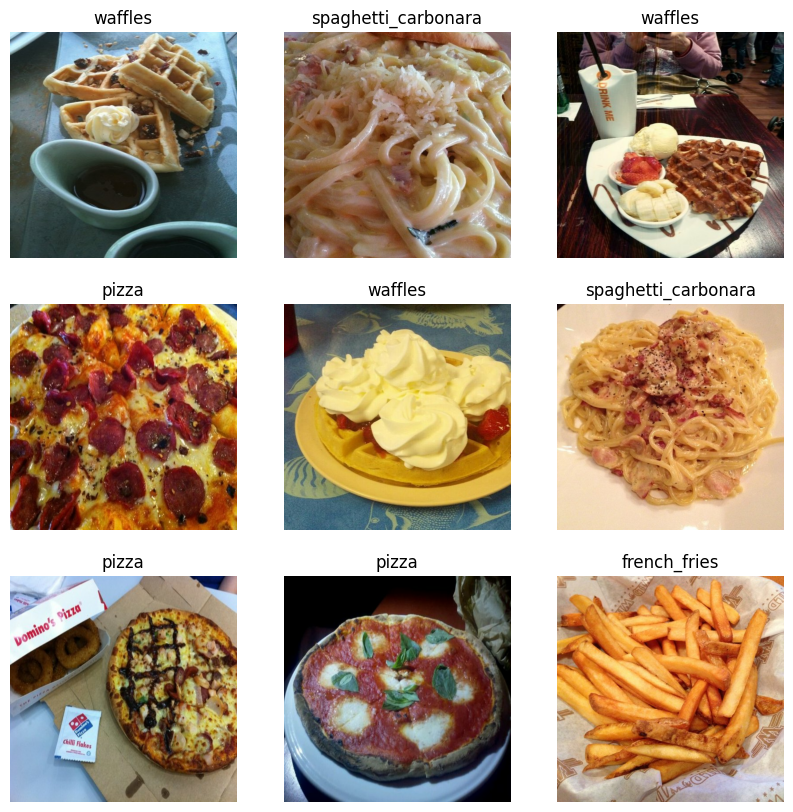

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# image_batch

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(34, 512, 512, 3)
(34,)


# Configure the dataset for performance
Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. (usefull to speedup training)

In [12]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network

Here, we standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [9]:
normalization_layer = layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# A basic Keras model 
(from the official TF documentation's tutorial for image classification) 

The Keras Sequential model consists of three convolution blocks (tf.keras.layers.Conv2D) with a max pooling layer (tf.keras.layers.MaxPooling2D) in each of them. There's a fully-connected layer (tf.keras.layers.Dense) with 128 units on top of it that is activated by a ReLU activation function ('relu'). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [15]:
num_classes = 4

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      1

In [18]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
95/95 [==============================] - 67s 690ms/step - loss: 1.8029 - accuracy: 0.4563 - val_loss: 1.1675 - val_accuracy: 0.5025
Epoch 2/10
95/95 [==============================] - 71s 751ms/step - loss: 0.9852 - accuracy: 0.6006 - val_loss: 1.0331 - val_accuracy: 0.6175
Epoch 3/10
95/95 [==============================] - 78s 819ms/step - loss: 0.6346 - accuracy: 0.7641 - val_loss: 1.2039 - val_accuracy: 0.5525
Epoch 4/10
95/95 [==============================] - 75s 786ms/step - loss: 0.2930 - accuracy: 0.8984 - val_loss: 2.1722 - val_accuracy: 0.5188
Epoch 5/10
95/95 [==============================] - 74s 778ms/step - loss: 0.2269 - accuracy: 0.9262 - val_loss: 1.8377 - val_accuracy: 0.5688
Epoch 6/10
95/95 [==============================] - 68s 718ms/step - loss: 0.0623 - accuracy: 0.9822 - val_loss: 2.3886 - val_accuracy: 0.5850
Epoch 7/10
95/95 [==============================] - 75s 791ms/step - loss: 0.0410 - accuracy: 0.9884 - val_loss: 2.3302 - val_accuracy: 0.5888

# Visualize training results

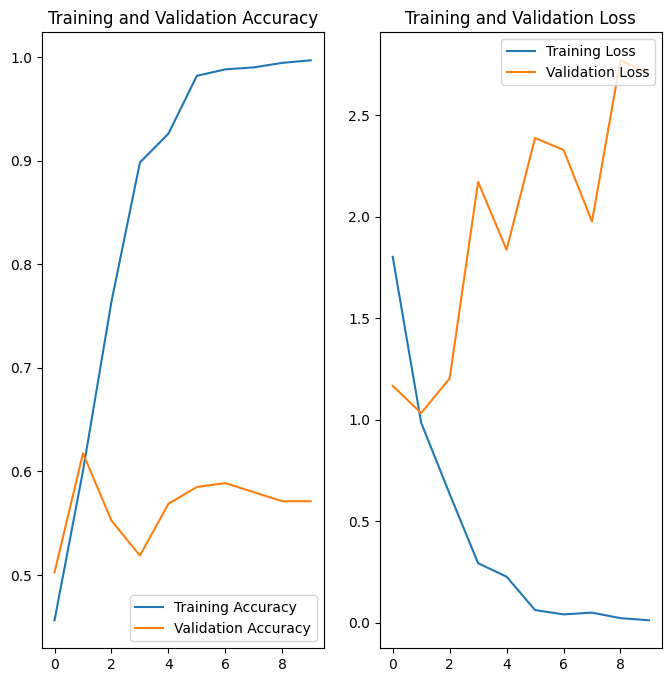

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 57% accuracy on the validation set. (Overffiting)

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

# Possible Solutions ? 
<ul>
    <li> Data Augmentation </li>
    <li> Dropout </li>
    <li> Transfer Learning</li>
    
</ul>

# Dropout
Apply dropout to a layer randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [33]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 256, 256, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 64)     

In [37]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
95/95 [==============================] - 80s 846ms/step - loss: 1.2156 - accuracy: 0.4478 - val_loss: 1.1320 - val_accuracy: 0.5425
Epoch 2/15
95/95 [==============================] - 150s 2s/step - loss: 1.0255 - accuracy: 0.5822 - val_loss: 1.0586 - val_accuracy: 0.5537
Epoch 3/15
95/95 [==============================] - 150s 2s/step - loss: 0.8278 - accuracy: 0.6750 - val_loss: 0.9647 - val_accuracy: 0.6150
Epoch 4/15
95/95 [==============================] - 148s 2s/step - loss: 0.5678 - accuracy: 0.7966 - val_loss: 1.2478 - val_accuracy: 0.5925
Epoch 5/15
95/95 [==============================] - 146s 2s/step - loss: 0.3161 - accuracy: 0.8906 - val_loss: 1.7618 - val_accuracy: 0.5612
Epoch 6/15
95/95 [==============================] - 161s 2s/step - loss: 0.1513 - accuracy: 0.9569 - val_loss: 1.8384 - val_accuracy: 0.5600
Epoch 7/15
95/95 [==============================] - 162s 2s/step - loss: 0.0840 - accuracy: 0.9791 - val_loss: 1.9106 - val_accuracy: 0.5913
Epoch 8/15


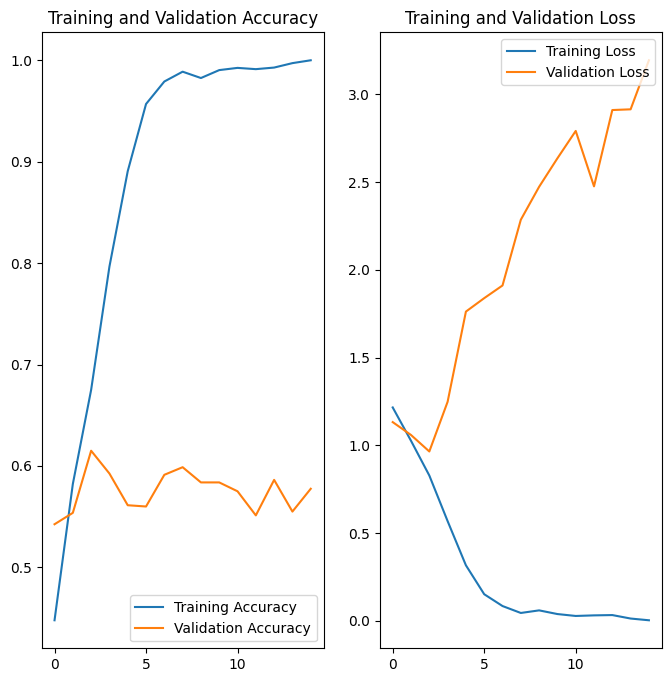

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [39]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes, name="outputs")
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
95/95 [==============================] - 156s 2s/step - loss: 1.7775 - accuracy: 0.3847 - val_loss: 1.4256 - val_accuracy: 0.2688
Epoch 2/15
95/95 [==============================] - 156s 2s/step - loss: 1.0816 - accuracy: 0.5612 - val_loss: 1.0152 - val_accuracy: 0.6000
Epoch 3/15
95/95 [==============================] - 160s 2s/step - loss: 0.8832 - accuracy: 0.6622 - val_loss: 0.9945 - val_accuracy: 0.6112
Epoch 4/15
95/95 [==============================] - 160s 2s/step - loss: 0.6127 - accuracy: 0.7778 - val_loss: 1.1476 - val_accuracy: 0.6025
Epoch 5/15
95/95 [==============================] - 174s 2s/step - loss: 0.3664 - accuracy: 0.8706 - val_loss: 1.2644 - val_accuracy: 0.6413
Epoch 6/15
95/95 [==============================] - 156s 2s/step - loss: 0.2207 - accuracy: 0.9256 - val_loss: 1.5475 - val_accuracy: 0.6200
Epoch 7/15
95/95 [==============================] - 152s 2s/step - loss: 0.1612 - accuracy: 0.9425 - val_loss: 1.7378 - val_accuracy: 0.5975
Epoch 8/15
95

In [43]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes, name="outputs")
])

In [44]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
epochs = 12
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/12
95/95 [==============================] - 75s 781ms/step - loss: 3.2096 - accuracy: 0.2978 - val_loss: 1.3464 - val_accuracy: 0.3550
Epoch 2/12
95/95 [==============================] - 90s 945ms/step - loss: 1.2272 - accuracy: 0.4519 - val_loss: 1.2902 - val_accuracy: 0.4487
Epoch 3/12
95/95 [==============================] - 91s 963ms/step - loss: 1.1472 - accuracy: 0.4984 - val_loss: 1.3923 - val_accuracy: 0.3063
Epoch 4/12
95/95 [==============================] - 96s 1s/step - loss: 1.0869 - accuracy: 0.5478 - val_loss: 1.3393 - val_accuracy: 0.3288
Epoch 5/12
95/95 [==============================] - 102s 1s/step - loss: 0.9707 - accuracy: 0.6122 - val_loss: 1.1879 - val_accuracy: 0.4538
Epoch 6/12
95/95 [==============================] - 103s 1s/step - loss: 0.8152 - accuracy: 0.6806 - val_loss: 1.1415 - val_accuracy: 0.5487
Epoch 7/12
95/95 [==============================] - 99s 1s/step - loss: 0.6317 - accuracy: 0.7534 - val_loss: 1.3338 - val_accuracy: 0.5225
Epoch 8/1

In [46]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, name="outputs")
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
95/95 [==============================] - 68s 706ms/step - loss: 1.5813 - accuracy: 0.3759 - val_loss: 1.1184 - val_accuracy: 0.5400
Epoch 2/15
95/95 [==============================] - 70s 733ms/step - loss: 1.1621 - accuracy: 0.5094 - val_loss: 1.1357 - val_accuracy: 0.5663
Epoch 3/15
95/95 [==============================] - 78s 817ms/step - loss: 1.0013 - accuracy: 0.5962 - val_loss: 1.2734 - val_accuracy: 0.5150
Epoch 4/15
95/95 [==============================] - 74s 778ms/step - loss: 0.8555 - accuracy: 0.6644 - val_loss: 1.0438 - val_accuracy: 0.6037
Epoch 5/15
95/95 [==============================] - 70s 734ms/step - loss: 0.6207 - accuracy: 0.7706 - val_loss: 1.1750 - val_accuracy: 0.6037
Epoch 6/15
95/95 [==============================] - 79s 837ms/step - loss: 0.4634 - accuracy: 0.8281 - val_loss: 1.3120 - val_accuracy: 0.5938
Epoch 7/15
95/95 [==============================] - 70s 739ms/step - loss: 0.3190 - accuracy: 0.8838 - val_loss: 1.5733 - val_accuracy: 0.6162

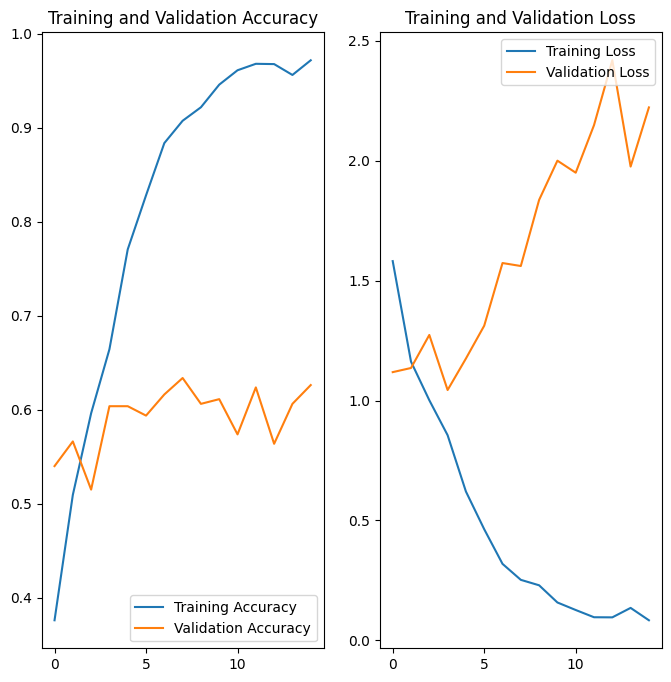

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data augmentation

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

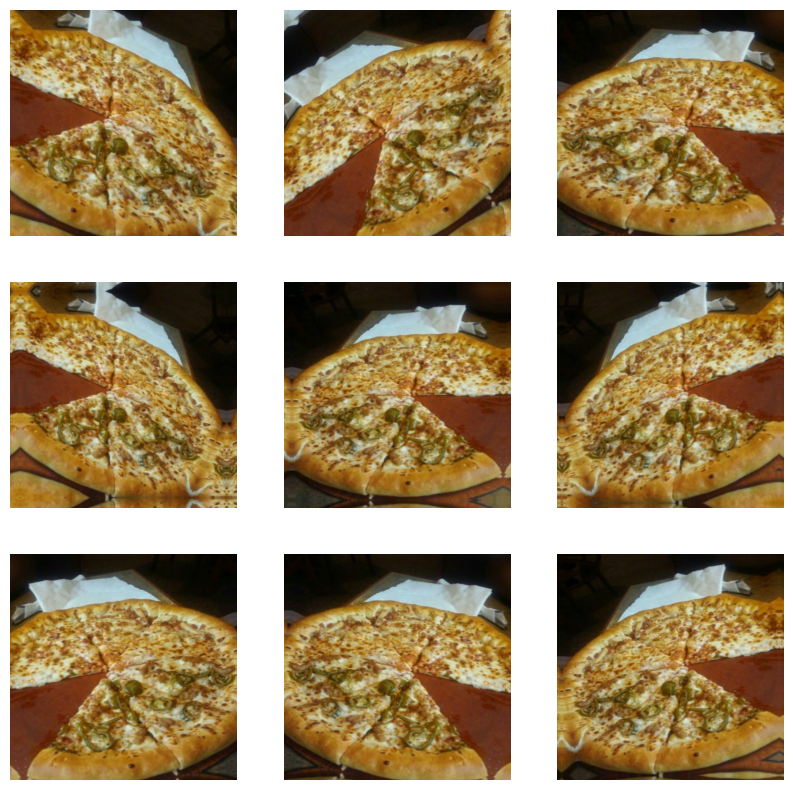

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(4, name="outputs")
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
95/95 [==============================] - 77s 800ms/step - loss: 2.2310 - accuracy: 0.3897 - val_loss: 1.1902 - val_accuracy: 0.4800
Epoch 2/50
95/95 [==============================] - 88s 924ms/step - loss: 1.1619 - accuracy: 0.4984 - val_loss: 1.1445 - val_accuracy: 0.4900
Epoch 3/50
95/95 [==============================] - 92s 963ms/step - loss: 1.1116 - accuracy: 0.5412 - val_loss: 1.0668 - val_accuracy: 0.5663
Epoch 4/50
95/95 [==============================] - 88s 926ms/step - loss: 1.0548 - accuracy: 0.5691 - val_loss: 1.0055 - val_accuracy: 0.5900
Epoch 5/50
95/95 [==============================] - 88s 923ms/step - loss: 1.0052 - accuracy: 0.5984 - val_loss: 1.0920 - val_accuracy: 0.5263
Epoch 6/50
95/95 [==============================] - 90s 950ms/step - loss: 0.9740 - accuracy: 0.6103 - val_loss: 0.9408 - val_accuracy: 0.6388
Epoch 7/50
95/95 [==============================] - 89s 939ms/step - loss: 0.9114 - accuracy: 0.6484 - val_loss: 1.3899 - val_accuracy: 0.4750

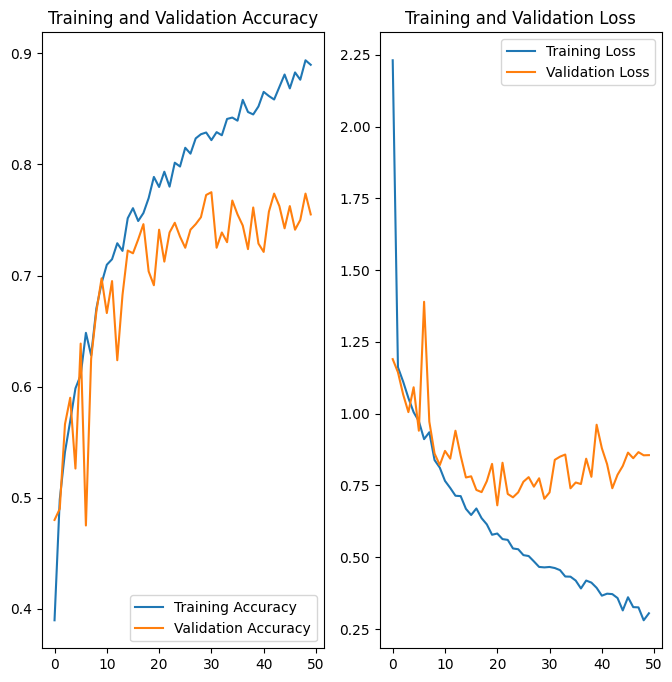

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()